In [2]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import pyDOE
from scipy.stats import pearsonr,spearmanr
from scipy.interpolate import interp1d

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1))

rez=600



In [39]:

def model(X,t):
    dY = np.zeros(7); #initialize the derivative
    S,AU,AP,LU,LP,E,V=X; #easier to read if variables actually spelled out
    
    #X[X<1e-6]=0
    
    Bt=Bt0*(1-1/(1+((Y1*np.exp(-k1*t)+Y2*np.exp(-k2*t))/IC50)**-h)) #infectivity depends on Ab
    
    dY[0] = aS - dS*S - Bt*S*V                         #susceptible cells
    dY[1] = (1-tau)*(1-lam)*Bt*S*V - dA*AU - k*E*AU + xi*LU    #active unproductively infected
    dY[2] = tau*(1-lam)*Bt*S*V - dA*AP - k*E*AP + xi*LP        #active productively infected
    dY[3] = (1-tau)*lam*Bt*S*V + thL*LU                #latent unproductively infected
    dY[4] = tau*lam*Bt*S*V + thL*LP                    #latent productively infected
    dY[5] = w*E*(AP+AU)/(E+E50) + aE - dE*E;           #adaptive immune system
    dY[6] = p*AP - g*V - Bt*S*V                        #virus
    return dY



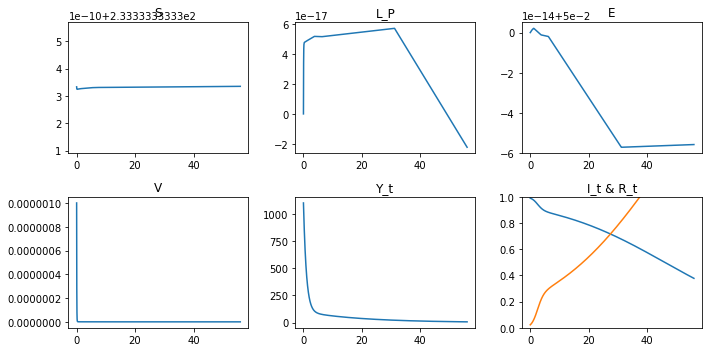

In [42]:
# parameters for viral dynamics model
vol = 1      # volume of blood [uL]
aS  = 70*vol;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.3;   #susceptible death rate [1/day] 
Bt0 = 1e-4/vol  # infection rate of T-cells [uL/cells-day]/[uL]
dA  = 1.0       # active death rate [1/day]
p   = 5e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 0.05      # productive infection probability []
lam = 1e-4      # latency probability []
thL = 5.2e-4    # latent clearance rate [1/day]
aL  = 0.015;    # latent proliferation rate [1/day] (Tcm)
xi  = 1e-5;     # latent activation rate [1/day]
dL  = aL-thL-xi # latent death rate
k   = 0.3/vol;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;     #immune cell multiplier [1/day]
aE  = 1e-4*vol;   #initial E cell concentration [cells/uL]*[uL]
dE  = 0.002;  #immune death rate [1/day]
E50 = 250*vol;   #50 pct max E cell concentration [cells/uL]*[uL]

R0=aS*Bt0*tau*(1-lam)*p/g/dS/dA; #basic reproductive number

#PK parameters
Y1,Y2,k1,k2 = 1e3, 100, 1, 0.05 #low 30 or high 10 dose range

#PD parameters
IC50=10 # IC50 [ug/uL]
h=1  # hill coefficient []

V0=1e-6 #1 virion in body!

X0=np.array([aS/dS,0,0,0,0,aE/dE,V0])

t=np.linspace(0,7*8,1e3) #time for antibody dose

Y_t,I_t=Ab_model(t,Y1,Y2,k1,k2,h,IC50) #Ab model

sol=spi.odeint(model, X0, t)  

vll=np.log10(sol[:,6]+0.001)

titz=['S','L_P','E','V','Y_t','I_t & R_t']
indz=[0,4,5,6]

plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2,3,i+1)
    plt.plot(t,sol[:,indz[i]])
    plt.title(titz[i])

plt.subplot(2,3,5)
plt.plot(t,Y_t)
plt.title(titz[4])

plt.subplot(2,3,6)
plt.plot(t,I_t)
plt.plot(t,R0*(1-I_t))
plt.ylim([0,1])
plt.title(titz[5])

#plt.subplot(2,5,10)
#plt.plot(t,R_t)

plt.tight_layout()
plt.savefig('figures/play.pdf')
